In [1]:
!pip install snntorch
!pip install optuna
!pip install scikit-learn
!pip install cmaes

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import snntorch
import snntorch.functional

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean, stdev
import random
from sklearn.metrics import confusion_matrix, accuracy_score
from importnb import Notebook
import tqdm
import copy

import optuna

/home/andreas/jupyter/eeg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with Notebook():
    from Preprocessing import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = data.to(device)
labels = labels.to(device)
subjects = subjects.to(device)
classes = labels[:, 1]

In [5]:
data.shape, labels.shape, subjects.shape

(torch.Size([9315, 6, 4096]), torch.Size([9315, 3]), torch.Size([9315]))

In [6]:
def segment(data, labels, subjects, size=1024, hop=512):
    '''Segment the data into smaller portions to enable "more" trials per subject. 
    The idea being that the training would be more stable.'''
    segments = []
    for start in range(0, data.size(2) - size + 1, hop):
        segments.append(data[:, :, start:start + size])  
    data = torch.cat(segments, dim=0)
    labels = labels.repeat_interleave(len(segments), dim=0)
    subjects = subjects.repeat_interleave(len(segments), dim=0)
    return data, labels, subjects

In [7]:
#data, labels, subjects = segment(data, labels, subjects)

In [8]:
#data.shape, labels.shape, subjects.shape

In [9]:
ratios = (8, 16, 32, 64, 128)
components_by_ratio = {}
filtered_data = None
for ratio in tqdm.tqdm(ratios, unit="ratio"):
    path = f"components_{ratio}.pt"
    if os.path.exists(path):
        components_by_ratio[ratio] = torch.load(path, weights_only=True).to(device)
    else:
        if filtered_data is None:
            filtered_data = bandpass_filter(robust_scaler(data.to("cpu")))
        components_by_ratio[ratio] = normalize(ica(downsample(filtered_data, 1024, 1024 // ratio))).to(device)
        torch.save(components_by_ratio[ratio].cpu(), path)

100%|██████████| 5/5 [00:00<00:00, 37.99ratio/s]


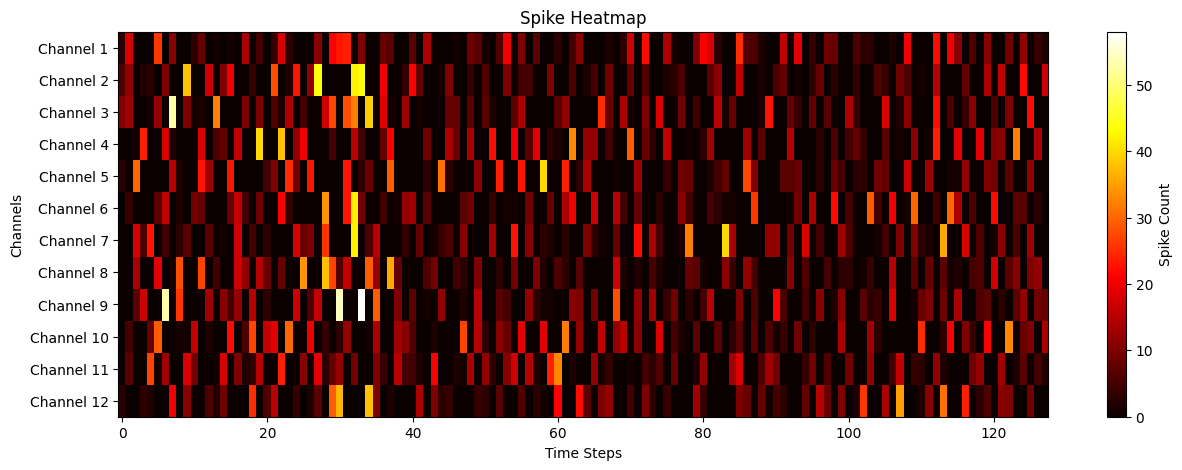

In [10]:
ratio = 32
spikes = delta_coding(components_by_ratio[ratio], delta=0.1)
plt.figure(figsize=(15, 5))
plt.imshow(spikes[0].cpu().numpy(), aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Count')
plt.xlabel('Time Steps')
plt.ylabel('Channels')
plt.title('Spike Heatmap')
plt.yticks(range(spikes.size(1)), [f'Channel {i+1}' for i in range(spikes.size(1))])
plt.show()
# Safety measure.
del spikes

In [11]:
mask1 = labels[:, 0] == modalities.index("Imagined")
mask2 = labels[:, 2] == artifacts.index("None")
mask3 = labels[:, 1] <= stimuli.index("U")

# Include artifacts due to filtering and small dataset.
#mask = mask1 & mask2 & mask3
mask = mask1 & mask3

# Make training and test sets. 80% 10% 10% split.
torch.manual_seed(42)
half = torch.rand_like(mask, dtype=torch.float) < 0.5
train_mask = mask & (torch.rand_like(mask, dtype=torch.float) < 0.8)
valid_mask = mask & ~train_mask & half
test_mask = mask & ~train_mask & ~half

subject_masks = [(subjects == i) for i in range(max(subjects) + 1)]

In [12]:
class LifParClassifier(torch.nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 layers=2,
                 gain=None,
                 bias=None,
                 learn_beta=False,
                 learn_threshold=False,
                 spike_grad=snntorch.surrogate.fast_sigmoid()):
        super().__init__()
        sizes = [(input_size, hidden_size)] + [(hidden_size, hidden_size)] * (layers-2) + [(hidden_size, output_size)]
        self.lifs = torch.nn.ModuleList(
            [snntorch.LeakyParallel(in_size,
                                    out_size,
                                    learn_threshold=learn_threshold,
                                    learn_beta=learn_beta,
                                    spike_grad=spike_grad) for in_size, out_size in sizes])

        for name, param in self.named_parameters():
            if gain is not None and 'weight' in name:
                torch.nn.init.xavier_normal_(param, gain=gain)
            elif bias is not None and 'bias' in name:
                torch.nn.init.constant_(param, bias)
            
    def forward(self, x):
        for lif in self.lifs:
            x = lif(x)             
        return x


In [13]:
# Courtesy of o1.
def add_undecided(logits, dim=1):
    """
    Adds an extra column to the logits tensor. The column has a value of 1
    for rows where all values are equal, and 0 otherwise.

    Args:
        logits (torch.Tensor): Input tensor of logits.
        dim (int): Dimension along which to check equality.

    Returns:
        torch.Tensor: Logits tensor with an additional column.
    """
    all_equal = (torch.diff(logits, dim=dim) == 0).all(dim=dim, keepdim=True)
    undecided_column = all_equal.float()
    return torch.cat([logits, undecided_column], dim=dim)


[I 2024-12-26 22:00:22,010] Trial 52 finished with value: 1.546242512596978 and parameters: {'ratio': 64, 'batch_size': 11, 'hidden_size': 82, 'layers': 3, 'epochs': 39, 'gain': 0.6005550058773368, 'bias': 1.26895833175114, 'lr': 0.0012949235619228023, 'delta': 0.32924796712462945}. Best is trial 52 with value: 1.546242512596978.

In [14]:
epics = []

def objective(trial):
    ratio = trial.suggest_categorical('ratio', ratios)
    batch_size = trial.suggest_int('batch_size', 7, 16)
    hidden_size = trial.suggest_int('hidden_size', 23, 128, log=True)
    layers = trial.suggest_int('layers', 2, 5)
    epochs = trial.suggest_int('epochs', 10, 50)
    gain = trial.suggest_float('gain', 0.5, 1.5)
    bias = trial.suggest_float('bias', 0.01, 2.0)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    delta = trial.suggest_float('delta', 0.01, 0.5, log=True)
    
    spikes = delta_coding(components_by_ratio[ratio], delta=delta)
    
    step_subject = list(range(15))
    random.shuffle(step_subject)
    epics = []
    for step in range(15):
        subject = step_subject[step]
        
        # Applies the masks for training and validation plus the mask for the subject
        # on the spikes and classes (labels). Done for each run for each subject.
        # Use a sampler to fight class imbalance optimizing for single class output.
        indices = train_mask & subject_masks[subject]
        class_weights = 1.0 / (torch.bincount(classes[indices]) + 1e-6)
        sample_weights = class_weights[classes[indices]]
        sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        
        loader = DataLoader(
            TensorDataset(spikes[indices], classes[indices]),
            batch_size=batch_size,
            collate_fn=collate,
            sampler=sampler
        )
        valid_loader = DataLoader(
            TensorDataset(spikes[valid_mask & subject_masks[subject]],
                          classes[valid_mask & subject_masks[subject]]),
            batch_size=batch_size,
            collate_fn=collate,
            shuffle=True)
        # Define the architecture 
        net = LifParClassifier(input_size=spikes.size(1),
                               hidden_size=hidden_size,
                               output_size=5,
                               layers=layers,
                               gain=gain,
                               bias=bias,
                               learn_threshold=True,
                               learn_beta=True
                              ).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        criterion1 = snntorch.functional.ce_rate_loss()
        criterion2 = snntorch.functional.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
        # Plain vanilla training loop
        losses = []
        valid_losses = []
        progress = tqdm.tqdm(range(epochs), unit="epoch")
        for epoch in progress:
            batch_losses = []
            net.train()    
            for events, targets in loader:
                optimizer.zero_grad()
                loss = criterion1(net(events), targets)
                loss += criterion2(net(events), targets)
                loss.backward()
                optimizer.step()
                batch_losses += [loss.item()]
        
            valid_batch_losses = []
            net.eval()
            with torch.no_grad():
                for events, targets in valid_loader:
                    loss = criterion1(net(events), targets)
                    loss += criterion2(net(events), targets)
                    valid_batch_losses += [loss.item()]
                    
            losses += [mean(batch_losses)]
            valid_losses += [mean(valid_batch_losses)]
        
            progress.set_description(f'Loss: {losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f},')
        epics += [min(valid_losses)]
        trial.report(mean(epics), step=step)
        #if mean(epics) > 5:
        #    raise optuna.exceptions.TrialPruned()
        #if step >= 2 and mean(epics) > 1.6093:
        #    raise optuna.exceptions.TrialPruned()

    return mean(epics)


In [ ]:
storage_url = "sqlite:///eegsnnparlifcer.db"
study = optuna.create_study(study_name="eegsnnparlifcermsecomb",
                            storage=storage_url,
                            load_if_exists=True)

study.optimize(objective, n_trials=100)

[I 2024-12-30 08:39:47,500] A new study created in RDB with name: eegsnnparlifcermsecomb
Loss: 161.6518, Validation Loss: 162.1906,: 100%|██████████| 16/16 [00:17<00:00,  1.07s/epoch]
[I 2024-12-30 08:43:30,710] Trial 0 finished with value: 179.03046213785808 and parameters: {'ratio': 8, 'batch_size': 14, 'hidden_size': 46, 'layers': 3, 'epochs': 16, 'gain': 0.7696721245389687, 'bias': 1.1577979938418381, 'lr': 5.020545431485584e-06, 'delta': 0.3022223584173443}. Best is trial 0 with value: 179.03046213785808.
Loss: 111.7227, Validation Loss: 120.6147,: 100%|██████████| 13/13 [00:09<00:00,  1.31epoch/s]
[I 2024-12-30 08:45:25,096] Trial 1 finished with value: 96.09381815592448 and parameters: {'ratio': 16, 'batch_size': 16, 'hidden_size': 82, 'layers': 4, 'epochs': 13, 'gain': 0.6758233897049186, 'bias': 1.3176420283281227, 'lr': 1.003472819888201e-05, 'delta': 0.030935587265288254}. Best is trial 1 with value: 96.09381815592448.
Loss: 99.4382, Validation Loss: 99.7740,: 100%|█████████

In [ ]:
study.best_params